In [95]:
from astropy.table import Table,join
import os
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as pyfits
from scipy import interpolate
from astropy.cosmology import FlatLambdaCDM
import matplotlib.colors as colors

import matplotlib.pyplot as plt

%matplotlib inline
plt.rc('font',**{'family':'serif','size':14})
#plt.rc('text', usetex=True)

plt.rcParams['text.usetex'] = False

"""
#plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':64})
## for Palatino and other serif fonts use:
plt.rc('font',**{'family':'serif','size':22})
plt.rc('text', usetex=True)"""

"\n#plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':64})\n## for Palatino and other serif fonts use:\nplt.rc('font',**{'family':'serif','size':22})\nplt.rc('text', usetex=True)"

In [96]:



home_dir = os.path.expanduser('~')
data_sbi_path = os.path.join(home_dir, 'Master_Thesis', 'DATA', 'DES_DF_SBI')
data_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')

In [97]:
"""
# COMOS

sbi_file_path = os.path.join(data_sbi_path, "DES_DF_COSMOS_sbi_output.fits")  
t= Table.read(sbi_file_path)
t2 = Table.read(os.path.join(data_path, "COSMOS_masked_cat.fits") )

"""



'\n# COMOS\n\nsbi_file_path = os.path.join(data_sbi_path, "DES_DF_COSMOS_sbi_output.fits")  \nt= Table.read(sbi_file_path)\nt2 = Table.read(os.path.join(data_path, "COSMOS_masked_cat.fits") )\n\n'

In [98]:
"""
# SN-C3
sbi_file_path = os.path.join(data_sbi_path, "DES_DF_SN-C3_sbi_output.fits")  
t= Table.read(sbi_file_path)
t2 = Table.read(os.path.join(data_path, "SN-C3_masked_cat.fits") )
"""


'\n# SN-C3\nsbi_file_path = os.path.join(data_sbi_path, "DES_DF_SN-C3_sbi_output.fits")  \nt= Table.read(sbi_file_path)\nt2 = Table.read(os.path.join(data_path, "SN-C3_masked_cat.fits") )\n'

In [99]:

# SN-X3
sbi_file_path = os.path.join(data_sbi_path, "DES_DF_SN-X3_sbi_output.fits")  
t= Table.read(sbi_file_path)
t2 = Table.read(os.path.join(data_path, "SN-X3_masked_cat.fits") )


In [100]:
"""
# SN-E2
sbi_file_path = os.path.join(data_sbi_path, "DES_DF_SN-E2_sbi_output.fits")  
t= Table.read(sbi_file_path)
t2 = Table.read(os.path.join(data_path, "SN-E2_masked_cat.fits") )
"""

'\n# SN-E2\nsbi_file_path = os.path.join(data_sbi_path, "DES_DF_SN-E2_sbi_output.fits")  \nt= Table.read(sbi_file_path)\nt2 = Table.read(os.path.join(data_path, "SN-E2_masked_cat.fits") )\n'

In [101]:
# load the file we made (yours will be the combined fits files of the subpieces you ran)
#t = Table.read("DES_DF_COSMOS_sbi_output_part5.fits")


# We should apply the cross match with the masked cat before doing this.
#t2 = Table.read("COSMOS_masked_cat.fits")
t = join(t,t2,keys='id')

In [102]:
# We'll use a mag limit at i<25, where we should be pretty much complete in terms of detection
# Other cuts are to remove objects that ended up with weird results somehow
# Basic cuts
mag_limit = 25.

cut = np.where((t['mode_z']>0)&
               (t['mode_z']<8)&
               (t['mode_mass']>0.)&
               (t['mode_mass']<12.5)&
               (t['bdf_mag_dered_calib_i']<mag_limit))
t = t[cut]


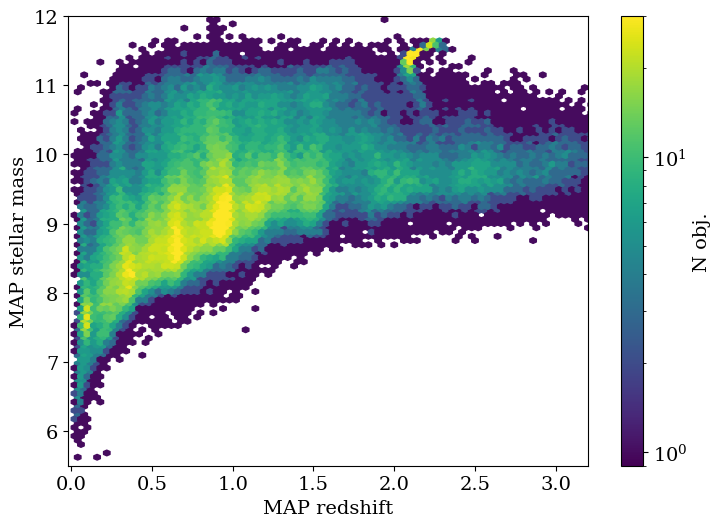

In [103]:
# plot the mode redshift and stellar mass values
fig = plt.figure(figsize=(7.5,5.5))
ax = fig.add_subplot(111)
s = ax.hexbin(t['mode_z'], t['mode_mass'], extent=(0,4,5.5,12.5), bins=50,
         norm=colors.LogNorm(vmin=0.9, vmax=30))
ax.set_xlim([-0.02,3.2])
ax.set_ylim([5.5,12.])
ax.set_xlabel(r'MAP redshift')
ax.set_ylabel(r'MAP stellar mass')
plt.tight_layout()
plt.colorbar(s, label='N obj.')
#plt.savefig("zM_SBI_output.png")
plt.show()

In [104]:
# The method assumes that the measured redshifts, masses and mass-to-light ratios are
# good enough that we can use them to approximate the real distribution.
# Galaxies at the mag limit will have a biased set of M/L ratios, because we are mass incomplete.
# OTOH, the brightest galaxies at any given redshift have a different distribution in M/L ratios than
# fainter objects. So we select galaxies brighter than our mag limit where we believe we're reasonably 
# mass complete, but are also representative of the target population (the target is objects at the 
# mag limit we've imposed).
# There are smarter methods we could use, but this is generally good enough.

# Base SEDs on 1-1.5 mag brighter 
z_arr = np.arange(0.1,2.05,0.05)

# We'll use a sliding window of width 0.2 to get enough objects for this to work ok.
# We can make them narrower if our catalogue is large enough.
mass_lim = []
for i,z in enumerate(z_arr):
    m_lim_set = np.where((t['bdf_mag_dered_calib_i'] < (mag_limit-1.))&
                         (t['bdf_mag_dered_calib_i'] > (mag_limit-1.5))&
                         (t['mode_z'] < z+0.1)&
                         (t['mode_z'] > z-0.1))
    
    # scale the mass of each galaxy to the mag limit we've imposed
    m_tmp = t[m_lim_set]['mode_mass'] - (mag_limit - t[m_lim_set]['bdf_mag_dered_calib_i'])/2.5
    
    # we'll define our limit as the 90% completeness limit (could use 95% if we want to be more conservative, 100% is a 
    # bad idea because there's often a crazy object and it's suceptible to bad objects / bad fits of individual objects)
    mass_lim.append(sorted(m_tmp)[int(len(m_tmp)*0.9)])

mass_lim = np.array(mass_lim)

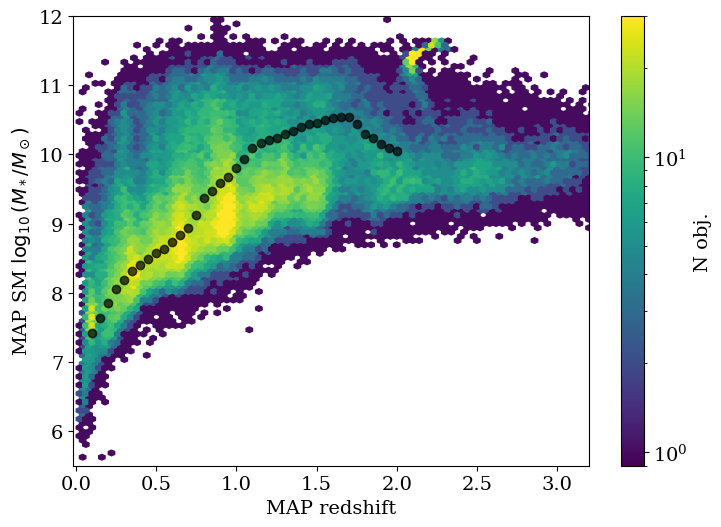

In [105]:
fig = plt.figure(figsize=(7.5,5.5))
ax = fig.add_subplot(111)
s = ax.hexbin(t['mode_z'], t['mode_mass'], extent=(0,4,5.5,12.5), bins=50,
         norm=colors.LogNorm(vmin=0.9, vmax=30))
ax.scatter(z_arr, mass_lim, marker='o', c='black', alpha=0.7)
ax.set_xlim([-0.02,3.2])
ax.set_ylim([5.5,12.])
ax.set_xlabel(r'MAP redshift')
ax.set_ylabel(r'MAP SM $\log_{10}(M_*/M_\odot)$')
plt.tight_layout()
plt.colorbar(s, label='N obj.')
#plt.savefig("zM_SBI_output.png")
plt.show()

In [106]:
# Now we can define our mass completeness limit as the 90%-ile completeness limit at the 
# high-redshift end of our target redshift bin.
# For example, if we want to measure the correlation function in a 0.5 < z < 0.8 bin, then we
# find the limit at z=0.8
print(mass_lim[(z_arr>=0.8)][0])

# So we'd use, 9.4 as our limit for the 0.5 < z < 0.8 bin.

9.363287848848012


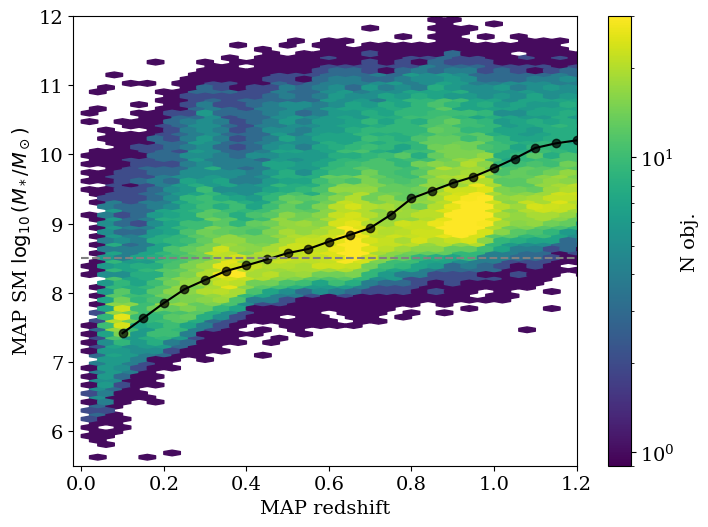

In [107]:
fig = plt.figure(figsize=(7.5,5.5))
ax = fig.add_subplot(111)
s = ax.hexbin(t['mode_z'], t['mode_mass'], extent=(0,4,5.5,12.5), bins=50,
         norm=colors.LogNorm(vmin=0.9, vmax=30))
ax.scatter(z_arr, mass_lim, marker='o', c='black', alpha=0.7)
ax.plot(z_arr, mass_lim, 'k-')
ax.plot([0,1.2],[8.5]*2, '--', c='gray')
ax.set_xlim([-0.02,1.2])
ax.set_ylim([5.5,12.])
ax.set_xlabel(r'MAP redshift')
ax.set_ylabel(r'MAP SM $\log_{10}(M_*/M_\odot)$')
plt.tight_layout()
plt.colorbar(s, label='N obj.')
#plt.savefig("zM_SBI_output_SM_completeness_COSMOS.png")

plt.show()

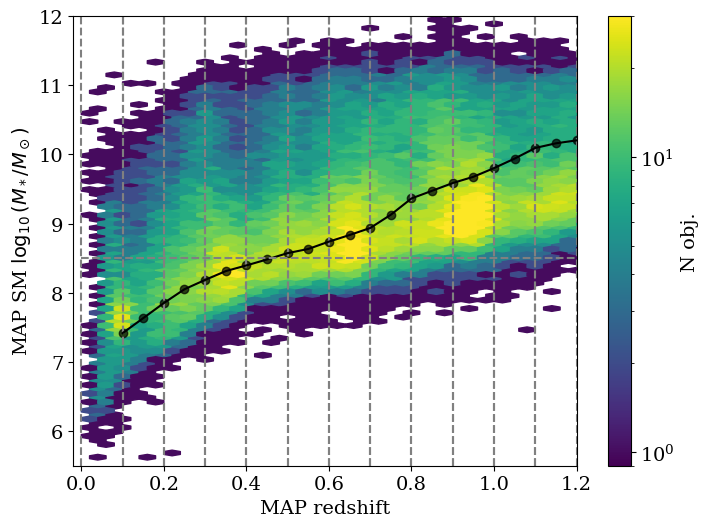

In [108]:
fig = plt.figure(figsize=(7.5,5.5))
ax = fig.add_subplot(111)
z_min, z_max = 0, 1.2

z_bins = np.arange(z_min, z_max + 0.01, 0.1)
for i in range(len(z_bins) - 1):
    z_min = z_bins[i]
    z_max = z_bins[i + 1]
    ax.axvline(z_min, linestyle='--', color='gray')
    ax.axvline(z_max, linestyle='--', color='gray')


s = ax.hexbin(t['mode_z'], t['mode_mass'], extent=(0,4,5.5,12.5), bins=50,
         norm=colors.LogNorm(vmin=0.9, vmax=30))
ax.scatter(z_arr, mass_lim, marker='o', c='black', alpha=0.7)
ax.plot(z_arr, mass_lim, 'k-')

sm_min, sm_max = 8.5, 12.5
z_bins = np.arange(sm_min, sm_max + 0.01, 0.5)

    


ax.plot([0,1.2],[8.5]*2, '--', c='gray')

ax.set_xlim([-0.02,1.2])
ax.set_ylim([5.5,12.])
ax.set_xlabel(r'MAP redshift')
ax.set_ylabel(r'MAP SM $\log_{10}(M_*/M_\odot)$')
plt.tight_layout()
plt.colorbar(s, label='N obj.')
#plt.savefig("zM_SBI_output_SM_completeness_COSMOS.png")

plt.show()

z_edge: 0.0 | mass_lim 7.4159422330849125
z_edge: 0.1 | mass_lim 7.4159422330849125
z_edge: 0.2 | mass_lim 7.8512239230555725
z_edge: 0.30000000000000004 | mass_lim 8.185560067782719
z_edge: 0.4 | mass_lim 8.395071053963004
z_edge: 0.5 | mass_lim 8.572885246423947
z_edge: 0.6000000000000001 | mass_lim 8.738956320106531
z_edge: 0.7000000000000001 | mass_lim 8.935988929343148
z_edge: 0.8 | mass_lim 9.363287848848012
z_edge: 0.9 | mass_lim 9.586088874349302
z_edge: 1.0 | mass_lim 9.802008592871756


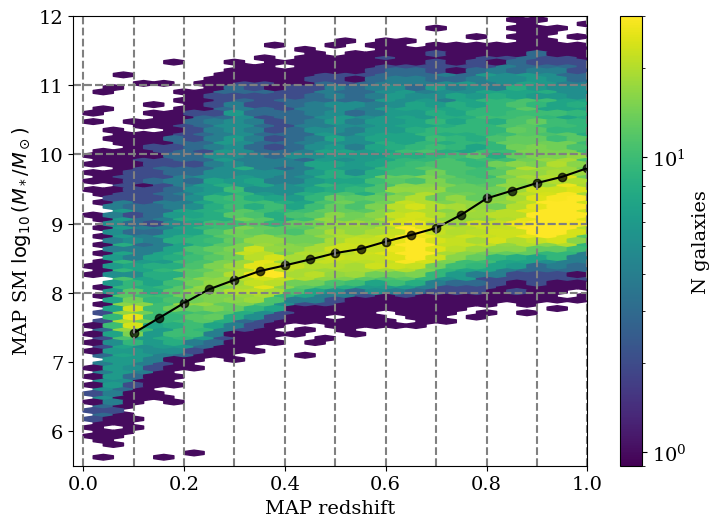

In [109]:
fig = plt.figure(figsize=(7.5, 5.5))
ax = fig.add_subplot(111)

z_min, z_max = 0, 1.
sm_min, sm_max = 8, 12.5
ax.set_xlim([z_min - 0.02, z_max])
ax.set_ylim([5.5,12.])

s = ax.hexbin(t['mode_z'], t['mode_mass'], extent=(0,4,5.5,12.5), bins=50,
         norm=colors.LogNorm(vmin=0.9, vmax=30))

# Plot mass completeness line
ax.scatter(z_arr, mass_lim, c='black', marker='o', alpha=0.7)
ax.plot(z_arr, mass_lim, 'k-', lw=1.5, label='Mass completeness limit')

# Plot vertical lines for redshift bins
z_bins = np.arange(z_min, z_max + 0.01, 0.1)
for z_edge in z_bins:
    ax.axvline(z_edge, linestyle='--', color='gray')
    print('z_edge:', z_edge, '| mass_lim', mass_lim[(z_arr>=z_edge)][0])


# Plot horizontal lines for stellar mass bins
SM_bins = [(8.0, 9.0), (9.0, 10.0), (10.0, 11.0), (11.0,12.5)]
for sm_min, sm_max in SM_bins:
    ax.axhline(sm_min, linestyle='--', color='gray')
    ax.axhline(sm_max, linestyle='--', color='gray')

ax.set_xlabel(r'MAP redshift')
ax.set_ylabel(r'MAP SM $\log_{10}(M_*/M_\odot)$')
plt.colorbar(s, label='N galaxies')
plt.tight_layout()

plt.savefig("zM_SBI_output_SM_completeness_SN_X3.png")
plt.show()
